In [1]:
import pandas as pd
from six.moves import cPickle
import numpy as np
from scipy.sparse import csr_matrix, lil_matrix
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error

In [2]:
from src import *
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt_color = ["#6A9A8B", "#00754B"]

In [3]:
yelp = pd.read_csv('../database/Yelp_final.csv', encoding='utf-8')

yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5127464 entries, 0 to 5127463
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   review_id    object 
 1   user_id      object 
 2   business_id  object 
 3   stars        float64
 4   true_stars   int64  
 5   city         object 
 6   categories   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 273.8+ MB


# 1 Filter out restaurant reviews located in Philadelphia

In [4]:
yelp_reviews = yelp[(yelp.city == 'Philadelphia')]

print("Number of rows and columns for restaurant reviews in Philadelphia:", yelp_reviews.shape)

Number of rows and columns for restaurant reviews in Philadelphia: (738852, 7)


Get the review data for Philadelphia restaurants

In [5]:
sparse_matrix_20 = get_sparse_matrix(get_clean_df(
    yelp_reviews,
    min_user_review=20,
    cols=['user_id', 'business_id', 'stars']))

sparse_matrix_30 = get_sparse_matrix(get_clean_df(
    yelp_reviews,
    min_user_review=30,
    cols=['user_id', 'business_id', 'stars']))

Compute the sparsity of the Philadelphia restaurant review dataset

In [6]:
print("Sparsity for users with at least 20 reviews:", get_sparsity(sparse_matrix_20))
print("Shape of the matrix for users with at least 20 reviews:", sparse_matrix_20.shape)

Sparsity for users with at least 20 reviews: 0.9929703612252491
Shape of the matrix for users with at least 20 reviews: (4996, 6904)


In [7]:
print("Sparsity for users with at least 30 reviews:", get_sparsity(sparse_matrix_30))
print("Shape of the matrix for users with at least 30 reviews:", sparse_matrix_30.shape)

Sparsity for users with at least 30 reviews: 0.9902944968534649
Shape of the matrix for users with at least 30 reviews: (2978, 6793)


Data where each user has at least 10 reviews

In [8]:
reviews_min_10 = get_clean_df(yelp_reviews,
                              min_user_review=10,
                              cols=['user_id', 'business_id', 'stars'])
print("Number of Philadelphia restaurant reviews:", reviews_min_10.shape[0])

Number of Philadelphia restaurant reviews: 350254


Number of unique restaurants and unique users

In [9]:
print("Number of unique restaurants in Philadelphia =", len(reviews_min_10.business_id.unique()))
print("Number of unique users in Philadelphia =", len(reviews_min_10.user_id.unique()))

Number of unique restaurants in Philadelphia = 7020
Number of unique users in Philadelphia = 12064


In [10]:
# Get the sparse matrix of Philadelphia restaurant ratings
ratings_sparse_matrix = get_sparse_matrix(reviews_min_10)
print("Shape of the Philadelphia restaurant rating matrix =", ratings_sparse_matrix.shape)

Shape of the Philadelphia restaurant rating matrix = (12064, 7020)


In [11]:
# Calculate the sparsity of the Philadelphia restaurant rating matrix
sparsity_Philadelphia = 1 - ratings_sparse_matrix.nnz / \
    (ratings_sparse_matrix.shape[0] * ratings_sparse_matrix.shape[1])
print("Sparsity of the Philadelphia restaurant rating matrix =", sparsity_Philadelphia)

Sparsity of the Philadelphia restaurant rating matrix = 0.9960676605114602


In [12]:
# Process the Philadelphia restaurant rating matrix
train_matrix, val_matrix, test_matrix = train_val_test_split(ratings_sparse_matrix)
print("Shape of Philadelphia training set:", train_matrix.shape)
print("Shape of Philadelphia validation set:", val_matrix.shape)
print("Shape of Philadelphia test set:", test_matrix.shape)

/root/miniconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:201: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


Shape of Philadelphia training set: (12064, 7020)
Shape of Philadelphia validation set: (12064, 7020)
Shape of Philadelphia test set: (12064, 7020)


Split the sparse matrix into training, validation, and test sets. Split Philadelphia user data with at least 20 reviews

In [13]:
train_matrix_users, val_matrix_users, test_matrix_users = train_val_test_split(
    sparse_matrix_20,
    num_review_val=7,
    num_review_test=3
)

print("Shape of Philadelphia user training set:", train_matrix_users.shape)
print("Shape of Philadelphia user validation set:", val_matrix_users.shape)
print("Shape of Philadelphia user test set:", test_matrix_users.shape)

Shape of Philadelphia user training set: (4996, 6904)
Shape of Philadelphia user validation set: (4996, 6904)
Shape of Philadelphia user test set: (4996, 6904)


# 2 Model Building:
## 2.1 Singular Value Decomposition (SVD)

In [14]:
# Perform SVD decomposition on the training matrix
U_Restaurant, S_Restaurant, Vt_Restaurant = np.linalg.svd(train_matrix.todense())

# Print the smallest and largest singular values
print("Smallest singular value =", min(S_Restaurant))
print("Largest singular value =", max(S_Restaurant))

# Diagonalize the singular values to create a diagonal matrix
S_res_dia = np.diag(S_Restaurant)

Smallest singular value = 1.855017812486091e-14
Largest singular value = 519.7943458321802


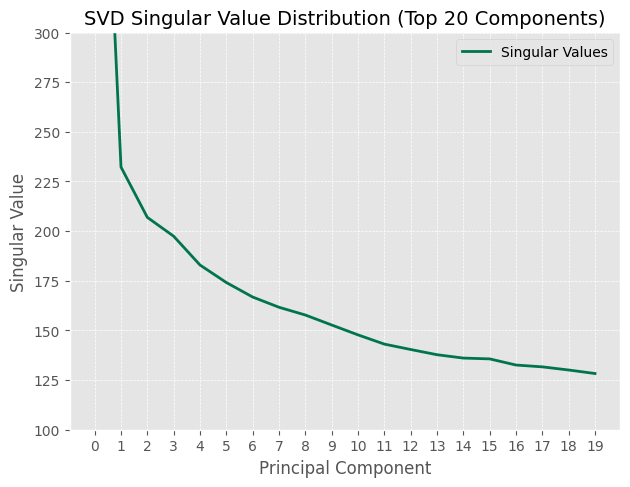

In [15]:
# Plot the first 20 singular values
plt.plot(S_Restaurant[:20], '-', linewidth=2,
         color=plt_color[1], label='Singular Values')

plt.xticks(np.arange(0, len(S_Restaurant[:20]), 1))

plt.grid(True, linestyle='--', linewidth=0.5)
plt.ylim(100, 300)

plt.legend()
plt.ylabel('Singular Value')
plt.xlabel('Principal Component')
plt.tight_layout()
plt.savefig('../static/experiments/Philadelphia/01_SVD_Singular_Value_Distribution_Top20.png', dpi=600)
plt.title('SVD Singular Value Distribution (Top 20 Components)', fontsize=14)
plt.show()

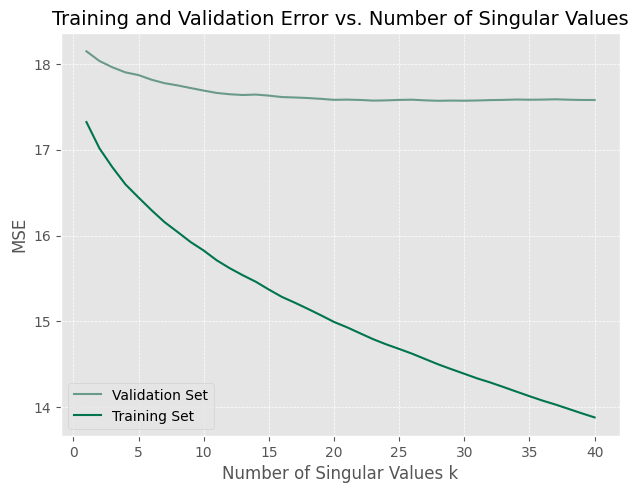

In [16]:
num_singular_values_range = np.arange(1, 41, 1)
validation_errors = {}
training_errors = {}

# Compute training and validation errors under different numbers of singular values
for num_singular_values in num_singular_values_range:
    validation_errors[num_singular_values] = compute_approximation_error(
        num_singular_values, val_matrix.todense(), U_Restaurant, S_res_dia, Vt_Restaurant)
    training_errors[num_singular_values] = compute_approximation_error(
        num_singular_values, train_matrix.todense(), U_Restaurant, S_res_dia, Vt_Restaurant)

# Plot the error curves
plt.plot(validation_errors.keys(), validation_errors.values(),
         label='Validation Set', color=plt_color[0])
plt.plot(training_errors.keys(), training_errors.values(),
         label='Training Set', color=plt_color[1])
plt.xlabel('Number of Singular Values k')
plt.ylabel('MSE')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc='lower left')

plt.tight_layout()
plt.savefig('../static/experiments/Philadelphia/02_Train_Validation_Error_vs_Singular_Values.png', dpi=600)
plt.title('Training and Validation Error vs. Number of Singular Values', fontsize=14)
plt.show()


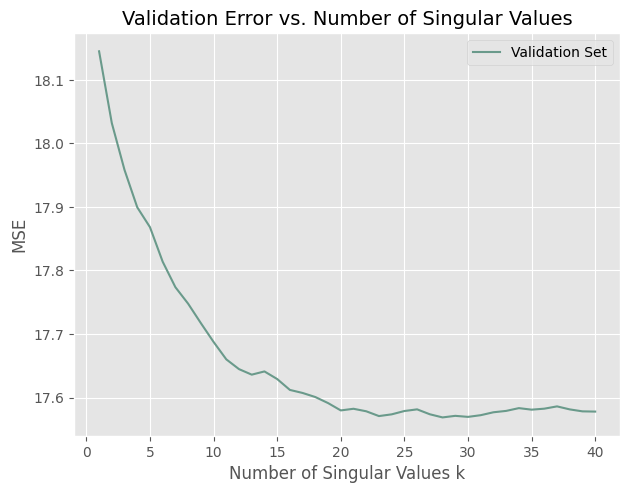

In [17]:
plt.plot(validation_errors.keys(), validation_errors.values(),
         label='Validation Set', color=plt_color[0])

plt.xlabel('Number of Singular Values k')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.savefig('../static/experiments/Philadelphia/03_Validation_Error_vs_Singular_Values.png', dpi=600)
plt.title('Validation Error vs. Number of Singular Values', fontsize=14)

plt.show()

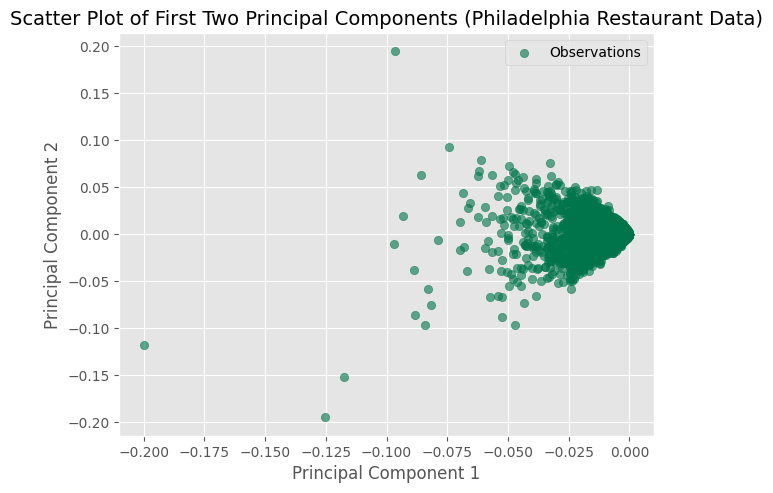

In [18]:
# Plot a scatter plot using the first two principal components from the SVD results
plt.scatter(np.ravel(U_Restaurant[:, 0]), np.ravel(
    U_Restaurant[:, 1]), label='Observations', color=plt_color[1], alpha=0.6)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.legend()
plt.tight_layout()
plt.savefig('../static/experiments/Philadelphia/04_First_Two_Principal_Components_Scatter.png', dpi=600)

plt.title('Scatter Plot of First Two Principal Components (Philadelphia Restaurant Data)', fontsize=14)
plt.show()

Compute the best validation MSE using SVD

Compute the best MSE on the validation set using the first 10 singular values for approximation on Philadelphia restaurant data

In [19]:
best_val_mse_svd = compute_approximation_error(
    num_singular_values=10,
    original_matrix=val_matrix.todense(),
    U=U_Restaurant,
    S=S_res_dia,
    Vt=Vt_Restaurant)

print('Best validation MSE using SVD on Philadelphia restaurant data = ', best_val_mse_svd)

Best validation MSE using SVD on Philadelphia restaurant data =  17.687599427144207


Get the indices of non-zero elements in the Philadelphia restaurant training, validation, and test sets

In [20]:
train_nonzero_indices = train_matrix.nonzero()
val_nonzero_indices = val_matrix.nonzero()
test_nonzero_indices = test_matrix.nonzero()

In [21]:
# Perform SVD reconstruction using the top 10 singular values, compute the reconstructed matrix
reconstructed_matrix_svd = np.dot(U_Restaurant[:, :10], np.dot(S_res_dia[:10, :10], Vt_Restaurant[:10, :]))

# Get the predicted values from the reconstructed matrix for the training, validation, and test sets
train_predictions_svd = np.ravel(reconstructed_matrix_svd[train_nonzero_indices])
val_predictions_svd = np.ravel(reconstructed_matrix_svd[val_nonzero_indices])
test_predictions_svd = np.ravel(reconstructed_matrix_svd[test_nonzero_indices])

## 2.2 Bias-Corrected SVD

In [22]:
# Compute the global bias of the Philadelphia restaurant training matrix
global_bias = np.sum(train_matrix) / train_matrix.nnz

# Training matrix after removing global bias
train_matrix_wo_bias = train_matrix.todense() - global_bias

# Perform SVD on the bias-removed training matrix
U_wo_bias, S_wo_bias, Vt_wo_bias = np.linalg.svd(train_matrix_wo_bias)

# Print the smallest and largest singular values
print("Smallest singular value =", min(S_wo_bias))
print("Largest singular value =", max(S_wo_bias))

# Diagonalize the singular values to create a diagonal matrix
S_diag_wo_bias = np.diag(S_wo_bias)

Smallest singular value = 1.3785817385781924e-13
Largest singular value = 37362.616113302065


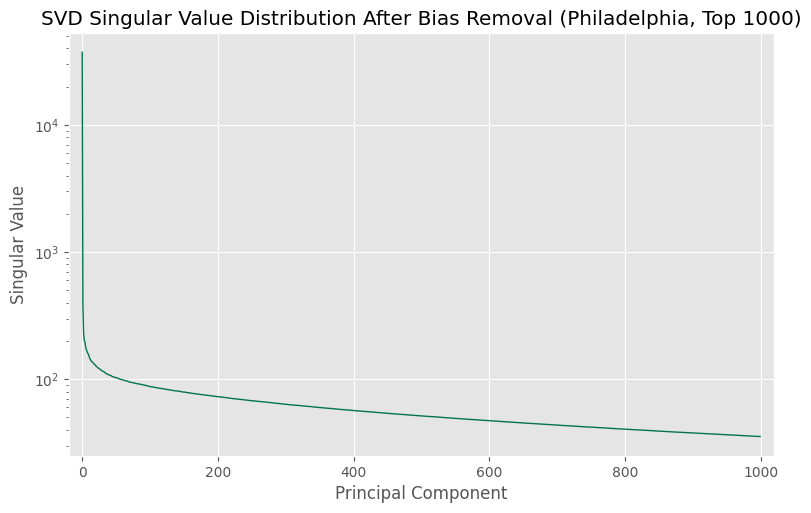

In [23]:
# Plot an Elbow chart of the first 1000 singular values
fig = plt.figure(figsize=(8, 5))
plt.semilogy(S_wo_bias[:1000], '-', linewidth=1, color=plt_color[1])
plt.xlim(-20, 1020)
plt.xlabel('Principal Component')
plt.ylabel('Singular Value')
plt.tight_layout()
plt.savefig('../static/experiments/Philadelphia/05_SVD_After_Bias_Removal_Singular_Values_Top1000.png', dpi=600)
plt.title('SVD Singular Value Distribution After Bias Removal (Philadelphia, Top 1000)')
plt.show()

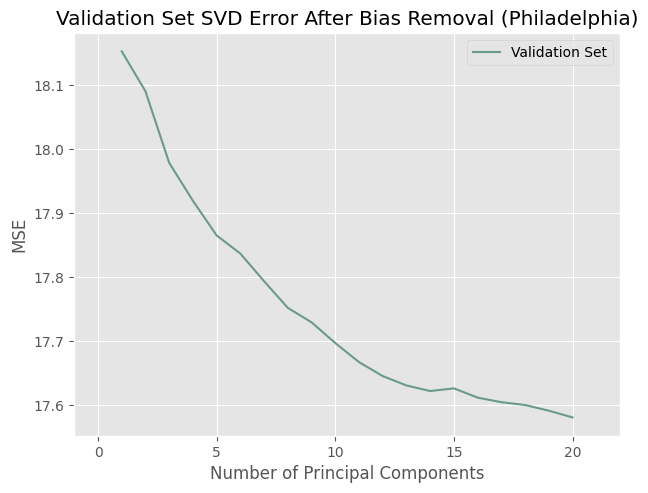

In [24]:
# Compute SVD error after bias removal
k_wo_bias = np.arange(1, 21)
errors_svd_wo_bias = {}
sm_u_10_res_val_wo_bias = val_matrix.todense() - global_bias

for i in k_wo_bias:
    sm_u_10_res_val_wo_bias_rec = np.dot(U_wo_bias[:, :i], np.dot(
        S_diag_wo_bias[:i, :i], Vt_wo_bias[:i, :]))
    idx_wo_bias = np.where(val_matrix.todense() > 0)
    diff_wo_bias = sm_u_10_res_val_wo_bias[idx_wo_bias] - \
        sm_u_10_res_val_wo_bias_rec[idx_wo_bias]
    errors_svd_wo_bias[i] = np.linalg.norm(
        diff_wo_bias)**2 / diff_wo_bias.shape[1]

# Plot the error curve
plt.plot(errors_svd_wo_bias.keys(),
         errors_svd_wo_bias.values(), color=plt_color[0],
         label='Validation Set')
plt.xlim(-1, 22)
plt.xlabel('Number of Principal Components')
plt.ylabel('MSE')
plt.legend()
plt.tight_layout()
plt.savefig('../static/experiments/Philadelphia/06_SVD_After_Bias_Removal_Validation_Reconstruction_Error.png', dpi=600)
plt.title('Validation Set SVD Error After Bias Removal (Philadelphia)')
plt.show()

In [25]:
# Compute user and item biases from the Philadelphia training matrix and remove the biases
user_bias, item_bias, train_matrix_no_bias = compute_global_user_item_bias(train_matrix)

/root/autodl-tmp/notebooks/src/models.py:41: RuntimeWarning: invalid value encountered in divide
  user_bias = np.sum(dense_matrix, axis=1) / np.sum(mask_matrix, axis=1)


In [26]:
# Perform SVD decomposition on the Philadelphia training matrix after removing user and item biases
U_no_bias, S_no_bias, Vt_no_bias = np.linalg.svd(train_matrix_no_bias)
print("Smallest singular value =", min(S_no_bias))
print("Largest singular value =", max(S_no_bias))
S_diag_no_bias = np.diag(S_no_bias)

Smallest singular value = 1.7977901409003095e-13
Largest singular value = 72957.48373463284


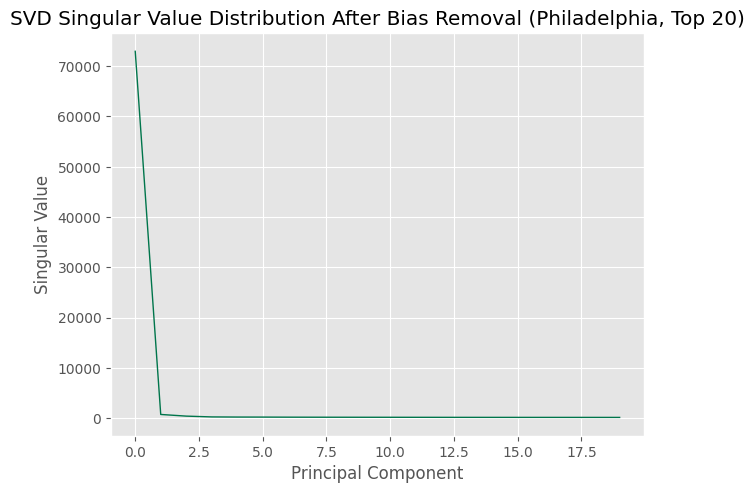

In [27]:
plt.plot(S_no_bias[:20], '-', linewidth=1, color=plt_color[1])

plt.xlabel('Principal Component')
plt.ylabel('Singular Value')

plt.tight_layout()
plt.savefig('../static/experiments/Philadelphia/07_SVD_After_Bias_Removal_Singular_Values_Top20.png', dpi=600)
plt.title('SVD Singular Value Distribution After Bias Removal (Philadelphia, Top 20)')
plt.show()

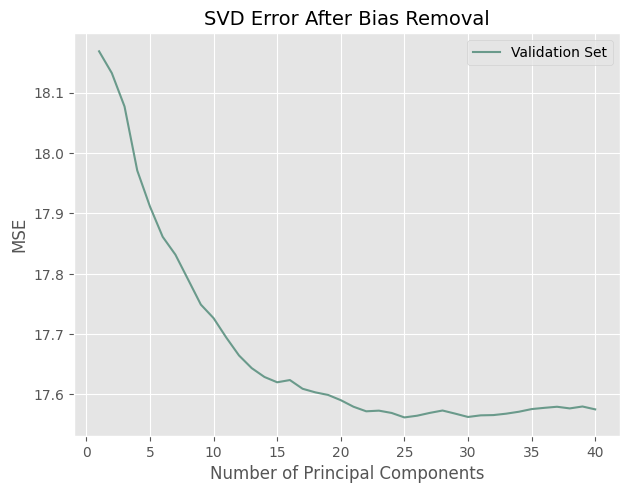

In [28]:
num_components_wo_bias = np.arange(1, 41, 1)
errors_svd_no_bias = {}
val_matrix_no_bias = val_matrix.todense() - user_bias - item_bias

# Compute SVD error after removing user and item biases
for test_features in num_components_wo_bias:
    reconstructed_val_matrix_no_bias = np.dot(U_no_bias[:, :test_features], np.dot(
        S_diag_no_bias[:test_features, :test_features], Vt_no_bias[:test_features, :]))
    non_zero_indices_no_bias = np.where(val_matrix.todense() > 0)
    diff_no_bias = val_matrix_no_bias[non_zero_indices_no_bias] - \
        reconstructed_val_matrix_no_bias[non_zero_indices_no_bias]
    errors_svd_no_bias[test_features] = np.linalg.norm(
        diff_no_bias)**2 / diff_no_bias.shape[1]

# Plot SVD error after bias removal
plt.plot(errors_svd_no_bias.keys(), errors_svd_no_bias.values(),
         label='Validation Set', color=plt_color[0])
plt.xlabel('Number of Principal Components')
plt.ylabel('MSE')

plt.legend()
plt.tight_layout()
plt.savefig('../static/experiments/Philadelphia/08_SVD_After_Bias_Removal_Validation_Reconstruction_Error.png', dpi=600)
plt.title('SVD Error After Bias Removal', fontsize=14)
plt.show()

## 2.3 Bias-adjusted Cosine Similarity

In [29]:
# Compute the restaurant similarity matrix
similarity_matrix_restaurant = compute_similarity_matrix(train_matrix, axis='res')
similarity_matrix_restaurant = np.array(similarity_matrix_restaurant)

# Predict ratings based on restaurant similarity
preds_cosine = predict_top_k(np.array(
    train_matrix.todense()), similarity_matrix_restaurant, kind='res', k=1)

# Compute the MSE for restaurant similarity predictions
MSE_cosine_res = calculate_mse(preds_cosine, np.array(val_matrix.todense()))
print("MSE based on cosine similarity between restaurants =", MSE_cosine_res)

MSE based on cosine similarity between restaurants = 18.747546215700904


In [30]:
# Compute the user similarity matrix
simi_users = compute_similarity_matrix(train_matrix, axis='users')
simi_users = np.array(simi_users)

# Predict ratings based on user similarity
preds_cosine_users = predict_top_k(
    np.array(train_matrix.todense()), simi_users, kind='user', k=1)

# Compute the MSE for user similarity predictions
MSE_cosine_users = calculate_mse(
    preds_cosine_users, np.array(val_matrix.todense()))
print("MSE based on cosine similarity between users =", MSE_cosine_users)

MSE based on cosine similarity between users = 18.747546215700904


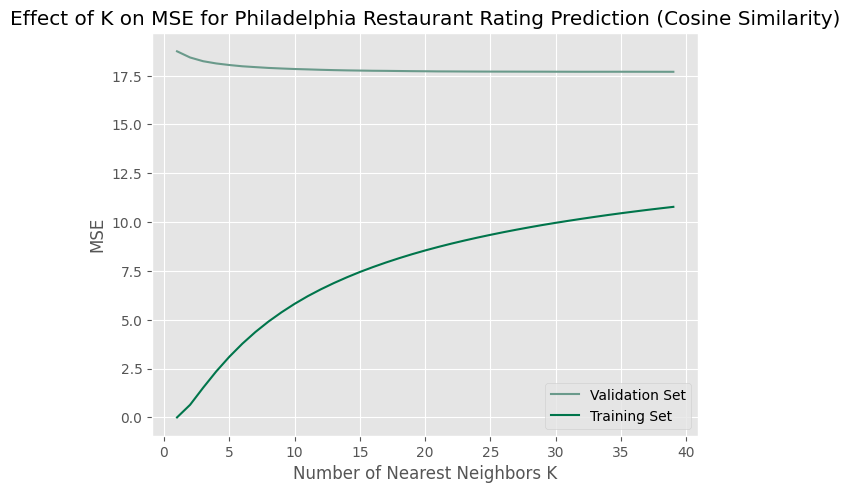

In [31]:
# Define empty dictionaries to store validation and training errors for different K values
errors_cs_res_val = {}
errors_cs_res_train = {}

# Define the range of K values
k_cs = np.arange(1, 40)

# Iterate over each K value and compute prediction MSE
for i in k_cs:
    # Predict ratings for Philadelphia restaurant data using cosine similarity
    preds_cs_res = predict_top_k(
        np.array(train_matrix.todense()), similarity_matrix_restaurant, kind='res', k=i)

    # Compute validation and training MSE
    error_cs_val = calculate_mse(
        preds_cs_res, np.array(val_matrix.todense()))
    error_cs_train = calculate_mse(
        preds_cs_res, np.array(train_matrix.todense()))

    # Store results in the dictionaries
    errors_cs_res_val[i] = error_cs_val
    errors_cs_res_train[i] = error_cs_train

# Plot the relationship between K values and MSE
plt.plot(errors_cs_res_val.keys(),
         errors_cs_res_val.values(), label='Validation Set', color=plt_color[0])
plt.plot(errors_cs_res_train.keys(),
         errors_cs_res_train.values(), label='Training Set', color=plt_color[1])

plt.xlabel('Number of Nearest Neighbors K')
plt.ylabel('MSE')
plt.legend()
plt.tight_layout()
plt.savefig('../static/experiments/Philadelphia/09_Cosine_Similarity_K_vs_MSE.png', dpi=600)
plt.title('Effect of K on MSE for Philadelphia Restaurant Rating Prediction (Cosine Similarity)')

plt.show()

Using cosine similarity and the optimal K value of 40 to predict the rating data of Philadelphia restaurants.

In [32]:
preds_cosine = predict_top_k(
    np.array(train_matrix.todense()), similarity_matrix_restaurant, kind='res', k=40)

# Calculate the MSE on the validation set using predictions from cosine similarity
Best_Val_MSE_Cosine = calculate_mse(
    preds_cosine, np.array(val_matrix.todense()))

# Print the best validation set MSE result for the cosine similarity model on Philadelphia restaurants
print('The best validation set MSE for the Philadelphia restaurant cosine similarity model at K=40 is = ',
      Best_Val_MSE_Cosine)

The best validation set MSE for the Philadelphia restaurant cosine similarity model at K=40 is =  17.70080111094016


In [33]:
train_prediction_cos = preds_cosine[train_nonzero_indices]
val_prediction_cos = preds_cosine[val_nonzero_indices]
test_prediction_cos = preds_cosine[test_nonzero_indices]

## 2.4 Alternating Least Squares (ALS)

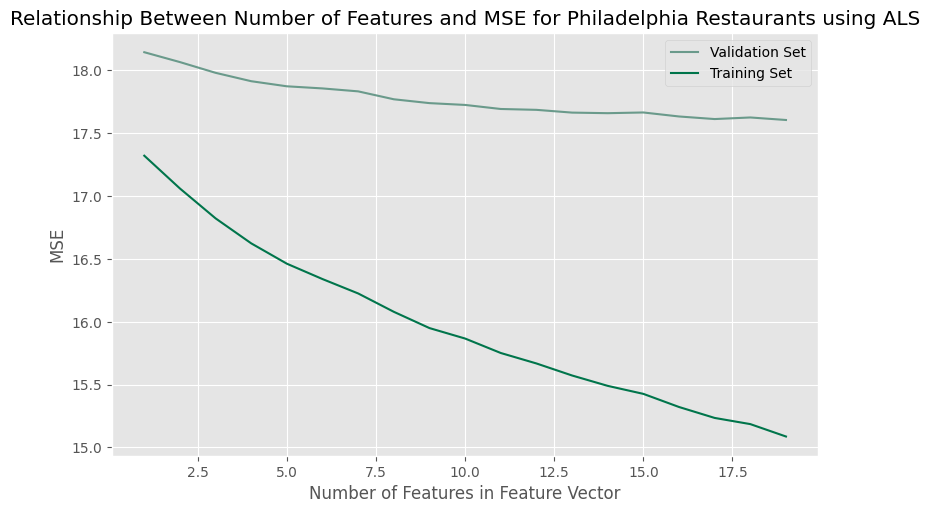

In [34]:
# Initialize different numbers of features and lists to store errors
num_features = np.arange(1, 20, 1)
test_error_als = []
train_error_als = []

# Iterate over different numbers of features
for i in num_features:
    # Perform prediction using Alternating Least Squares (ALS)
    preds_als = als(np.array(train_matrix.todense()),
                    num_features=i, iterations=5)

    # Compute MSE for validation and training sets
    test_err = calculate_mse(preds_als, np.array(val_matrix.todense()))
    train_err = calculate_mse(
        preds_als, np.array(train_matrix.todense()))

    # Append errors to lists
    test_error_als.append(test_err)
    train_error_als.append(train_err)

fig = plt.figure(figsize=(8, 5))

# Plot the relationship between number of features and MSE
plt.plot(num_features, test_error_als, label='Validation Set', color=plt_color[0])
plt.plot(num_features, train_error_als, label='Training Set', color=plt_color[1])

plt.xlabel('Number of Features in Feature Vector')
plt.ylabel('MSE')

plt.legend()
plt.tight_layout()
plt.savefig('../static/experiments/Philadelphia/10_ALS_Number_of_Features_vs_MSE.png', dpi=600)
plt.title('Relationship Between Number of Features and MSE for Philadelphia Restaurants using ALS')
plt.show()

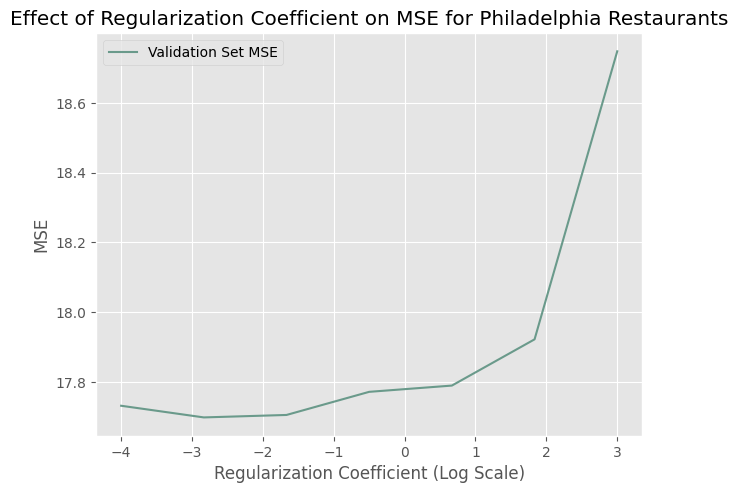

In [35]:
user_reg = np.logspace(-4, 3, 7)
val_error_als = {}  # Initialize dictionary to store validation set errors

# Iterate over different regularization parameters
for i in user_reg:
    # Initialize validation error list for the current regularization parameter
    val_error_als[i] = []

    # Perform prediction using the ALS algorithm, applying the same regularization to users and items
    preds_als = als(np.array(train_matrix.todense()), num_features=10,
                    iterations=5, user_regularization=i, item_regularization=i)

    # Compute and store the MSE on the validation set
    val_err = calculate_mse(preds_als, np.array(val_matrix.todense()))
    val_error_als[i].append(val_err)

# Plot the relationship between regularization parameter (log scale) and MSE
plt.plot(np.log10(user_reg), [
         errors[0] for errors in val_error_als.values()], label='Validation Set MSE', color=plt_color[0])

plt.xlabel('Regularization Coefficient (Log Scale)')
plt.ylabel('MSE')

plt.legend()
plt.tight_layout()
plt.savefig('../static/experiments/Philadelphia/11_ALS_Regularization_vs_MSE.png', dpi=600)
plt.title('Effect of Regularization Coefficient on MSE for Philadelphia Restaurants')
plt.show()

In [36]:
# Call the ALS function with 10 features, 5 iterations, and both user and item regularization set to 0.001
preds_als = als(ratings_matrix=np.array(train_matrix.todense()),
                    num_features=10,
                    iterations=5,
                    user_regularization=0.001,
                    item_regularization=0.001)

# Compute the MSE on the validation set using the calculate_mse function
Best_Val_MSE_als = calculate_mse(
    preds_als,
    np.array(val_matrix.todense()))

# Print the best MSE on the validation set
print('The best validation MSE for the ALS model on Philadelphia restaurants is:', Best_Val_MSE_als)

The best validation MSE for the ALS model on Philadelphia restaurants is: 17.74315879045523


In [37]:
train_prediction_als = preds_als[train_nonzero_indices]
val_prediction_als = preds_als[val_nonzero_indices]
test_prediction_als = preds_als[test_nonzero_indices]

## 2.5 Stochastic Gradient Descent with Bias Adjustment

Tuning Iterations: 100%|██████████| 41/41 [52:24<00:00, 76.70s/it] 


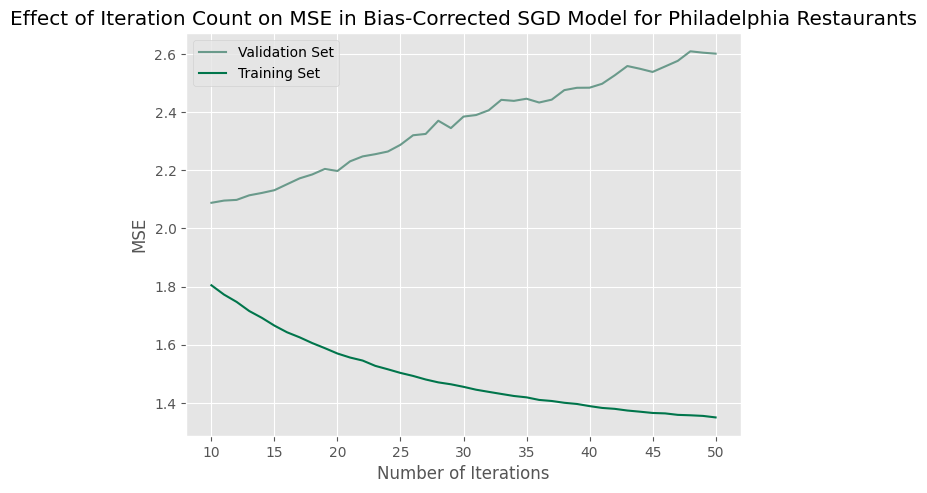

In [38]:
iters = np.arange(10, 51, 1)
err_sgd_test = []  # Store validation set errors
err_sgd_train = []  # Store training set errors

# Iterate over different numbers of iterations, tuning the Iters hyperparameter
from tqdm import tqdm

for i in tqdm(iters, desc='Tuning Iterations'):
    # Train the model using SGD with bias correction
    prediction_sgd_with_bias = sgd_with_bias_correction(
        np.array(train_matrix.todense()), num_features=10, iterations=i)

    # Compute MSE for validation and training sets
    err_test = calculate_mse(
        prediction_sgd_with_bias[0], np.array(val_matrix.todense()))
    err_train = calculate_mse(
        prediction_sgd_with_bias[0], np.array(train_matrix.todense()))

    # Append results to lists
    err_sgd_test.append(err_test)
    err_sgd_train.append(err_train)


# Plot the relationship between number of iterations and MSE
plt.plot(iters, err_sgd_test, label='Validation Set', color=plt_color[0])
plt.plot(iters, err_sgd_train, label='Training Set', color=plt_color[1])

plt.xlabel('Number of Iterations')
plt.ylabel('MSE')
plt.legend()
plt.tight_layout()
plt.savefig('../static/experiments/Philadelphia/12_SGD_with_Bias_MSE_vs_Iterations.png', dpi=600)
plt.title('Effect of Iteration Count on MSE in Bias-Corrected SGD Model for Philadelphia Restaurants')

plt.show()

note: We can set our optimal number of iterations = 20

Current number of features k =  1
Current number of features k =  2
Current number of features k =  3
Current number of features k =  4
Current number of features k =  5
Current number of features k =  6
Current number of features k =  7
Current number of features k =  8
Current number of features k =  9
Current number of features k =  10
Current number of features k =  11
Current number of features k =  12
Current number of features k =  13
Current number of features k =  14
Current number of features k =  15


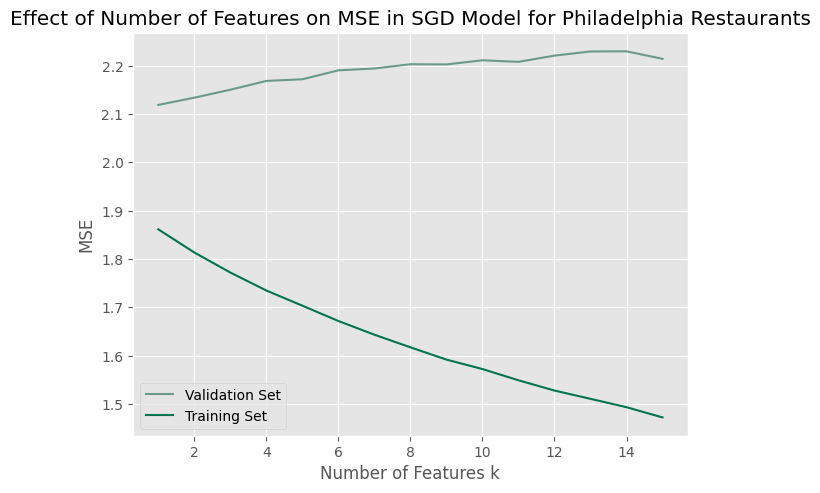

In [39]:
test_features = np.arange(1, 16, 1)
err_sgd_test = []
err_sgd_train = []

# Iterate over different numbers of features
for i in test_features:
    print('Current number of features k = ', i)

    prediction_sgd_with_bias = sgd_with_bias_correction(
        np.array(train_matrix.todense()), num_features=i, iterations=20)

    err_test = calculate_mse(
        prediction_sgd_with_bias[0], np.array(val_matrix.todense()))
    err_train = calculate_mse(
        prediction_sgd_with_bias[0], np.array(train_matrix.todense()))

    err_sgd_test.append(err_test)
    err_sgd_train.append(err_train)

# Plot the relationship between number of features and MSE
plt.plot(test_features, err_sgd_test, label='Validation Set', color=plt_color[0])
plt.plot(test_features, err_sgd_train, label='Training Set', color=plt_color[1])

plt.xlabel('Number of Features k')
plt.ylabel('MSE')

plt.legend()
plt.tight_layout()
plt.savefig('../static/experiments/Philadelphia/13_SGD_with_Bias_Features_vs_MSE.png', dpi=600)
plt.title('Effect of Number of Features on MSE in SGD Model for Philadelphia Restaurants')
plt.show()

We can set our optimal number of features k = 2

In [40]:
# Train the model using SGD with bias correction and obtain predictions, error array, user vectors, and item vectors
# Set number of features to 2 and number of iterations to 20
predictions_sgd, error_array_sgd, user_vec_sgd, res_vec_sgd = sgd_with_bias_correction(
    np.array(train_matrix.todense()),
    num_features=2, iterations=20)

In [41]:
# Re-run the SGD function to ensure prediction results are obtained
prediction_sgd_with_bias = sgd_with_bias_correction(
    np.array(train_matrix.todense()), num_features=2, iterations=20)

# Compute the mean squared error on the validation set
Best_Val_MSE_sgd = calculate_mse(
    prediction_sgd_with_bias[0], np.array(val_matrix.todense()))

# Print the best validation MSE
print('The best validation MSE for the SGD model on Philadelphia restaurants is:', Best_Val_MSE_sgd)


The best validation MSE for the SGD model on Philadelphia restaurants is: 2.1363751305036254


In [42]:
# Use the prediction results to make rating predictions at non-zero index positions in the training, validation, and test sets
train_prediction_sgd = prediction_sgd_with_bias[0][train_nonzero_indices]
val_prediction_sgd = prediction_sgd_with_bias[0][val_nonzero_indices]
test_prediction_sgd = prediction_sgd_with_bias[0][test_nonzero_indices]

## 2.6 Random Forest
Transforming the matrix completion problem into a regression problem

The Random Forest regressor attempts to learn the nonlinear relationship between user latent vectors and restaurant latent vectors. The target variable is the rating that user i gives to restaurant j. Essentially, this becomes a regression problem.

The core idea of transforming the matrix completion problem into a regression problem is to use the feature vectors of users and items (restaurants) to predict ratings. The goal of matrix completion is to fill in missing entries in the rating matrix, i.e., to predict ratings for items (restaurants) that users haven't rated yet. By converting the task into a regression problem, we can use the latent factors (feature vectors) to build a model that makes these rating predictions.


In [43]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(max_depth=5)

# Concatenate user and item feature vectors for training, validation, and testing
train = concatenate_user_item_vectors(user_vec_sgd, res_vec_sgd, train_matrix)
val = concatenate_user_item_vectors(user_vec_sgd, res_vec_sgd, val_matrix)
test = concatenate_user_item_vectors(user_vec_sgd, res_vec_sgd, test_matrix)


In [44]:
# Convert the concatenated vectors into NumPy arrays
train_mat = np.array(train)
val_mat = np.array(val)
test_mat = np.array(test)
x_train, y_train = train_mat[:, :-1], np.ravel(train_mat[:, -1])
x_val, y_val = val_mat[:, :-1], np.ravel(val_mat[:, -1])


In [45]:
rf.fit(train_mat[:, :4], train_mat[:, 4])
preds_rf = rf.predict(val_mat[:, :4]).reshape(-1, 1)
MSE_rf = calculate_mse(preds_rf, val_mat[:, 4])
print('Mean Squared Error of the Random Forest Regressor =', MSE_rf)

Mean Squared Error of the Random Forest Regressor = 2.379706170881286


In [46]:
train_prediction_rf = rf.predict(train_mat[:, :4])
val_prediction_rf = rf.predict(val_mat[:, :4])
test_prediction_rf = rf.predict(test_mat[:, :4])

# 3 Evaluation

Collection of all prediction models (SVD, Cosine Similarity, ALS, SGD, RF)

In [47]:
from sklearn.linear_model import LinearRegression

In [48]:
ensemble_training_df = build_ensemble_dataframe(
    svd_predictions=train_predictions_svd,
    cosine_predictions=train_prediction_cos,
    als_predictions=train_prediction_als,
    sgd_predictions=train_prediction_sgd,
    rf_predictions=train_prediction_rf
)

ensemble_validation_df = build_ensemble_dataframe(
    svd_predictions=val_predictions_svd,
    cosine_predictions=val_prediction_cos,
    als_predictions=val_prediction_als,
    sgd_predictions=val_prediction_sgd,
    rf_predictions=val_prediction_rf
)

ensemble_testing_df = build_ensemble_dataframe(
    svd_predictions=test_predictions_svd,
    cosine_predictions=test_prediction_cos,
    als_predictions=test_prediction_als,
    sgd_predictions=test_prediction_sgd,
    rf_predictions=test_prediction_rf
)

In [49]:
y_train = np.ravel(np.array(train_matrix[train_nonzero_indices]))
y_val = np.ravel(np.array(val_matrix[val_nonzero_indices]))
y_test = np.ravel(np.array(test_matrix[test_nonzero_indices]))

In [50]:
lr = LinearRegression(fit_intercept=True)
lr.fit(ensemble_training_df.iloc[:, -3:], y_train)
ensemble_val_pred = lr.predict(ensemble_validation_df.iloc[:, -3:])
MSE_ensemble = calculate_mse(ensemble_val_pred, y_val)
print('Mean Squared Error of the Ensemble Model =', MSE_ensemble)

Mean Squared Error of the Ensemble Model = 2.226386119409781


We apply ridge regression with high regularization

In [51]:
from sklearn.linear_model import Ridge
lrr = Ridge(alpha=10000)
lrr.fit(ensemble_training_df.iloc[:, -3:], y_train)
ensemble_val_pred = lrr.predict(
    ensemble_validation_df.iloc[:, -3:])
MSE_ensemble = calculate_mse(ensemble_val_pred, y_val)
print('Mean Squared Error of the Ensemble Model on the Validation Set =', MSE_ensemble)

Mean Squared Error of the Ensemble Model on the Validation Set = 2.186475806257871


Test the best model on the test data and evaluate its accuracy. The best model is the ensemble model.

In [52]:
ensemble_test_pred = lrr.predict(ensemble_testing_df.iloc[:, -3:])
MSE_test = calculate_mse(ensemble_test_pred, y_test)
print('Mean Squared Error of the Ensemble Model on the Test Set =', MSE_test)

Mean Squared Error of the Ensemble Model on the Test Set = 2.098699494586144
